# SIIM-ISIC Melanoma Classification- Identify melanoma in lesion images
https://www.kaggle.com/c/siim-isic-melanoma-classification/overview

# 1. Introduction
Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

# 2. Data Source
The images are provided in DICOM format. This can be accessed using commonly-available libraries like pydicom, and contains both image and metadata. It is a commonly used medical imaging data format.

Images are also provided in JPEG and TFRecord format (in the jpeg and tfrecords directories, respectively). Images in TFRecord format have been resized to a uniform 1024x1024.

Metadata is also provided outside of the DICOM format, in CSV files. See the Columns section for a description.

**Prediction Task-** predict a binary target for each image. The model should predict the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant (the target). In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant. For each image_name in the test set, we must predict the probability (target) that the sample is malignant. The file should contain a header and have the following format:
<img src="./images/sample.jpg" width="220" height="220" >



Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.

**Train Dataset Consists Of:<br>**
- image name -> the filename of specific image for the train set
- patient_id -> identifies the unique patient
- sex -> gender of the patient
- age_approx -> approx age of the patient at time of scanning
- anatom_site_general_challenge -> location of the scan site
- diagnosis -> information about the diagnosis
- benign_malignant - indicates scan result if it's malignant or benign
- target -> same as above but better for modelling since it's binary
And the next dataset we going to inspect test. It has same features as train set except for scan results.

**Test Dataset Consists Of:<br>**
- image name -> the filename of specific image for the train set
- patient_id -> identifies the unique patient
- sex -> gender of the patient
- age_approx -> approx age of the patient at time of scanning
- anatom_site_general_challenge -> location of the scan site

Let us import the necessary libraries first and also print a few data rows.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set Color Palettes for the notebook
colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
import plotly.express as px
# Setting plot styling.
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec

# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
black_red = [
    '#1A1A1D', '#4E4E50', '#C5C6C7', '#6F2232', '#950740', '#C3073F'
]

# Setting plot styling.
plt.style.use('fivethirtyeight')

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
img_stats_path = './data/jpeg/train/'
print("Train: Number of observations={} and number of features={}".format(train_data.shape[0], train_data.shape[1])) 
print("Test: Number of observations={} and number of features={}".format(test_data.shape[0], test_data.shape[1]))
print("sample Train data")
train_data.head(3)

Train: Number of observations=33126 and number of features=8
Test: Number of observations=10982 and number of features=5
sample Train data


image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0

Now, lets print the number of patients in Train and Test.

In [2]:
print("Number of patients in train dataset : ",train_data['patient_id'].nunique())
print("Number of patients in test dataset : ",test_data['patient_id'].nunique())
common_data = pd.merge(train_data,test_data,on=['patient_id','patient_id'])
print("Number of common patients in train and test dataset : ",common_data['patient_id'].nunique())
print("sample Test data")
test_data.head(3)

Number of patients in train dataset :  2056
Number of patients in test dataset :  690
Number of common patients in train and test dataset :  0
sample Test data


image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso

# 2. Missing Values

Our next task is to check how many missing values are there in Train

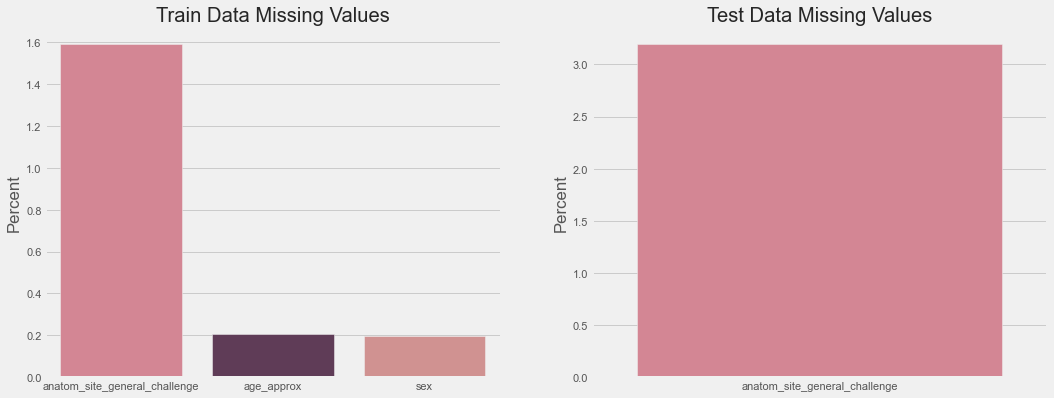

In [3]:
def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train_data)
missing_test = missing_percentage(test_data)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=colors_nude,
            ax=ax[0]);

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=colors_nude,
            ax=ax[1]);

ax[0].set_title('Train Data Missing Values');
ax[1].set_title('Test Data Missing Values');

From the above graphs, we can see that a small portion of missing values for age and sex.
So, there is no harm if we impute them with the most frequent ones. Meanwhile body parts missing on both datasets.
Our next job is to check the distributions for Sex, Age and Anatom_site_general_challenge before imputing them.

## 2.1 Imputing Sex feature

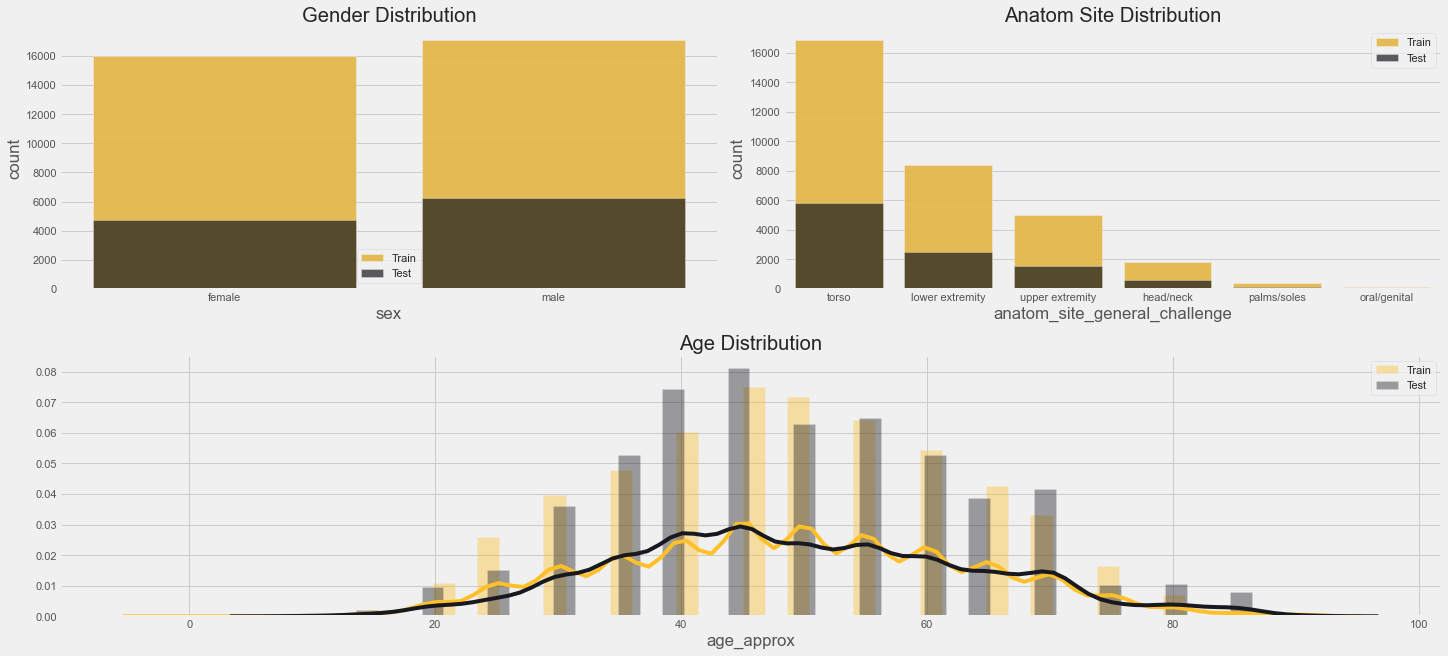

In [4]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train_data.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(test_data.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train_data.anatom_site_general_challenge,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train_data['anatom_site_general_challenge'].value_counts().index)
sns.countplot(test_data.anatom_site_general_challenge,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=test_data['anatom_site_general_challenge'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution');

# Plot the histogram.

sns.distplot(train_data.age_approx, ax=ax3, label='Train', color='#fdc029');
sns.distplot(test_data.age_approx, ax=ax3, label='Test', color='#171820');

ax3.legend();


From the above graphs, we can infer that
1. Sex has similar distibution in Train and Test(from first graph)
2. Anatom_site_general_challenge also has similar distibution in Train and Test (from second graph)
3. Age has a normal distribution in Train and Test(from third graph)

Next, let us analyse the Sex distribution the Benign and Malignant cases seperately.

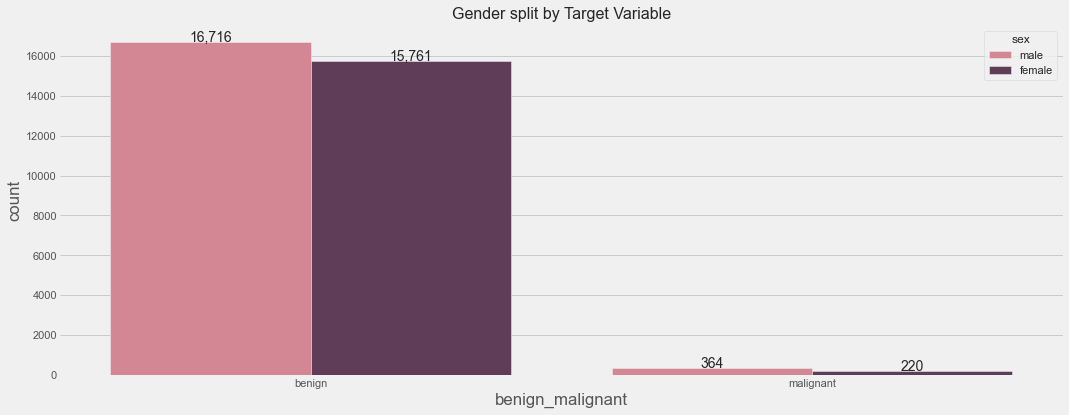

In [5]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=train_data, x='benign_malignant', hue='sex', palette=colors_nude)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

Following are our findings from the graphs:
- There are more males than females in the dataset
- However, the percentages are ~ the same

**Hence, we will impute the missing values in 'Sex' with the most common sex-male**

In [6]:
train_data['sex'].fillna("male", inplace = True) 

## 2.2 Imputing anatom_site_general_challenge feature

Before imputing the missing values in anatom_site_general_challenge, we will plot a tree map the see it's distribution Train first. 

In [7]:
# Train data:
cntstr = train_data.anatom_site_general_challenge.value_counts().rename_axis('anatom_site_general_challenge').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['anatom_site_general_challenge'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

Next, we will plot a tree map the see it's distribution Test first.

In [8]:
# Test data:

cntste = test_data.anatom_site_general_challenge.value_counts().rename_axis('anatom_site_general_challenge').reset_index(
    name='count')

fig = px.treemap(cntste,
                 path=['anatom_site_general_challenge'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Test Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

From the above 2 tree plots, it looks like both datasets shared scanned body parts similary. Let's check it further. There are missing values in this feature. Let us see the number of missing values in 'anatom_site_general_challenge' feature.

In [9]:
anatom_na = train_data[train_data['anatom_site_general_challenge'].isna()]
anatom_na.target.value_counts()

0    518
1      9
Name: target, dtype: int64

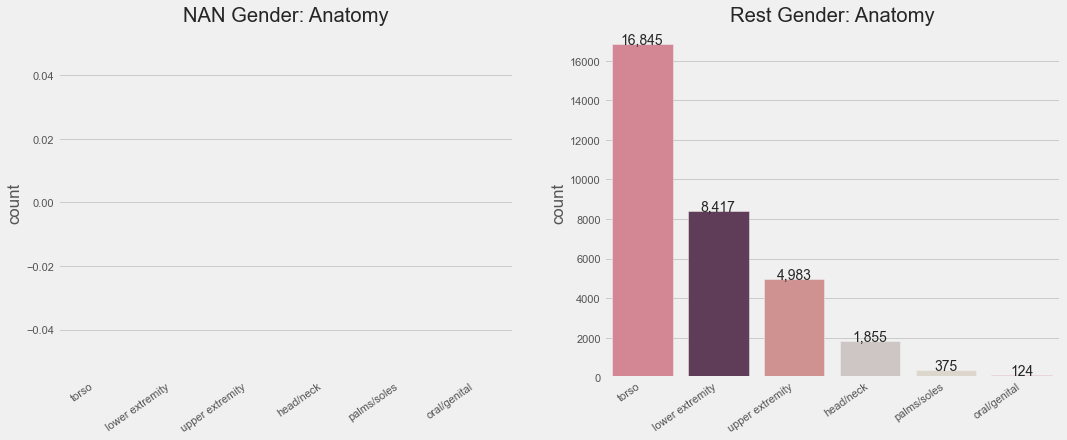

In [11]:
# Data
nan_sex = train_data[train_data['sex'].isna() == True]
is_sex = train_data[train_data['sex'].isna() == False]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_sex['anatom_site_general_challenge'], ax = ax1, palette=colors_nude, 
                  order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital'])
b = sns.countplot(is_sex['anatom_site_general_challenge'], ax = ax2, palette=colors_nude, 
                  order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital'])
ax1.set_title('NAN Gender: Anatomy')
ax2.set_title('Rest Gender: Anatomy')
ax1.set_xlabel('')
ax2.set_xlabel('')

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")


for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points');


for x in b.patches:
    b.annotate(format(x.get_height(), ','), 
           (x.get_x() + x.get_width() / 2., 
            x.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points');

# Benign/ Malignant check
# print('Out of 65 NAN values, {} are benign and 0 malignant.'.format(nan_sex['benign_malignant'].value_counts()[0]))

All missing values are benign and the majority of the patients have the Melanoma in the Lower Extremity, Upper Extremity and Torso. All values for diagnosis are unknown. Therefore, we'll use the most predominant gender that appears in these values to impute the missing values.

In [12]:
# Check how many are males and how many females
anatomy = ['lower extremity', 'upper extremity', 'torso']
train_data[(train_data['anatom_site_general_challenge'].isin(anatomy)) & (train_data['target'] == 0)]['sex'].value_counts()

male      15230
female    14523
Name: sex, dtype: int64

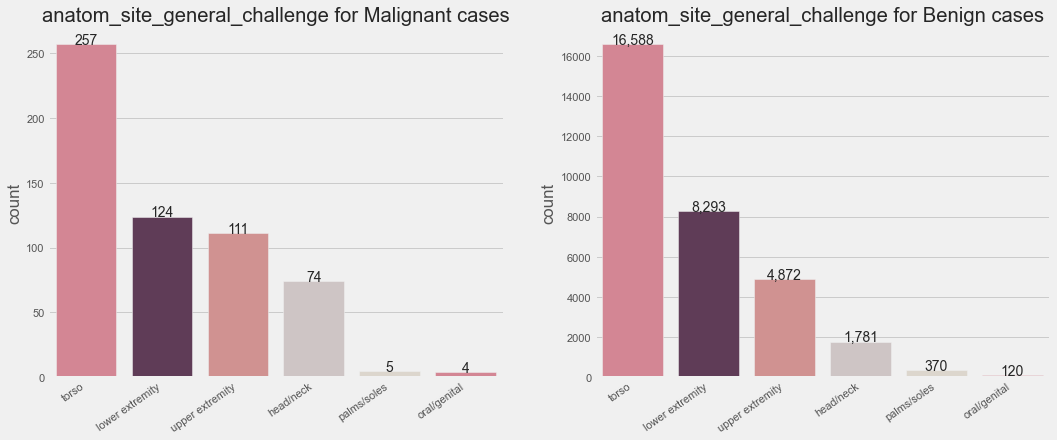

In [13]:
# Data
df_malignant = train_data[train_data['target'] == 1]
df_benign = train_data[train_data['target'] == 0]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(df_malignant['anatom_site_general_challenge'], ax = ax1, palette=colors_nude, 
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
b = sns.countplot(df_benign['anatom_site_general_challenge'], ax = ax2, palette=colors_nude,
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
ax1.set_title('anatom_site_general_challenge for Malignant cases');
ax2.set_title('anatom_site_general_challenge for Benign cases');
ax1.set_xlabel('');
ax2.set_xlabel('');

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right");
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right");


for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points');

    
for x in b.patches:
    b.annotate(format(x.get_height(), ','), 
           (x.get_x() + x.get_width() / 2., 
            x.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points');


From the above graphs, it looks like lesions in Torso, lower and upper proximity, head/neck all can be benign and Malignant cases. Next, let us check if there is difference in these anatomical locations in both genders.

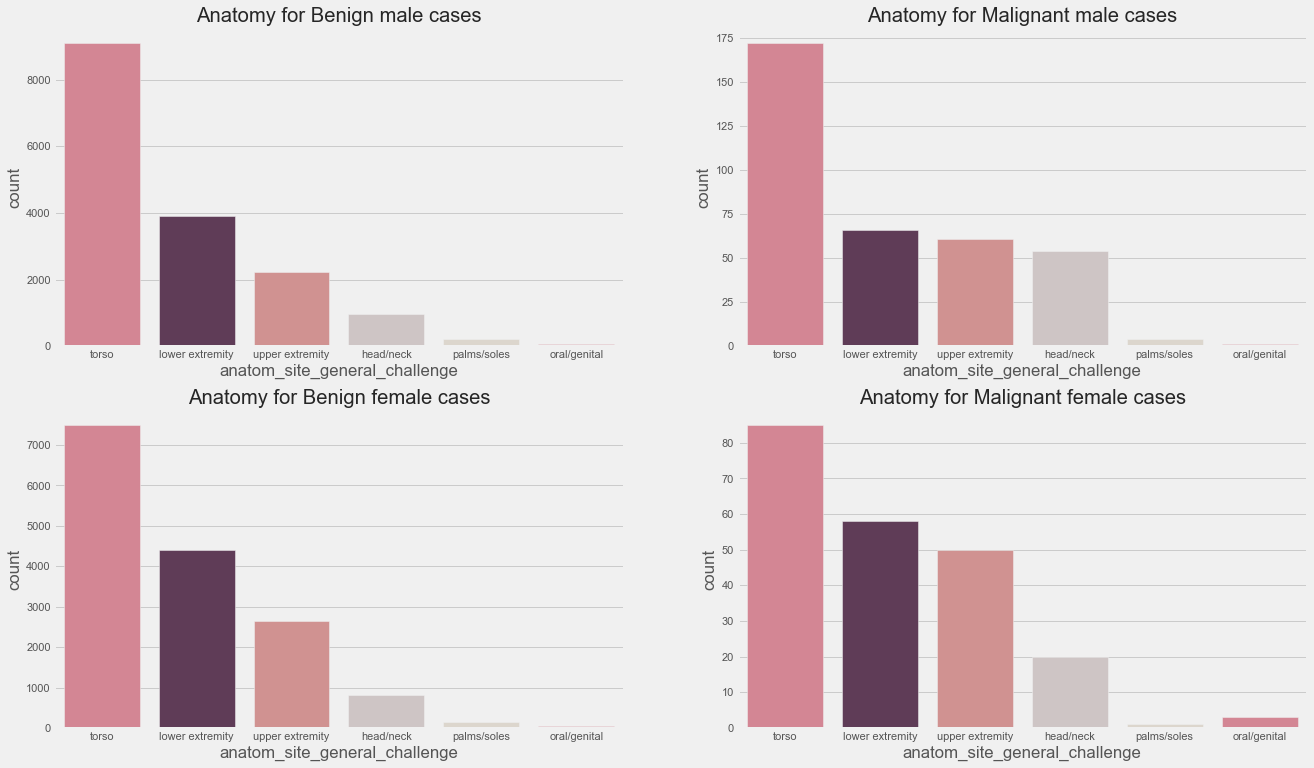

In [14]:
sns.set_palette("Paired")

f, ax = plt.subplots(2,2, figsize=(20,12))

df_male_benign = train_data[(train_data['target']==0) & (train_data['sex']=='male')]
df_male_malignant = train_data[(train_data['target']==1) & (train_data['sex']=='male')]
df_female_benign = train_data[(train_data['target']==0) & (train_data['sex']=='female')]
df_female_malignant = train_data[(train_data['target']==1) & (train_data['sex']=='female')]

a = sns.countplot(df_male_benign['anatom_site_general_challenge'], ax= ax[0,0],palette=colors_nude,
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
ax[0,0].set_title('Anatomy for Benign male cases');



b = sns.countplot(df_male_malignant['anatom_site_general_challenge'], ax= ax[0,1],palette=colors_nude,
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
ax[0,1].set_title('Anatomy for Malignant male cases');

    
c = sns.countplot(df_female_benign['anatom_site_general_challenge'], ax= ax[1,0],palette=colors_nude,
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
ax[1,0].set_title('Anatomy for Benign female cases');



d = sns.countplot(df_female_malignant['anatom_site_general_challenge'], ax= ax[1,1],palette=colors_nude,
                 order = ['torso', 'lower extremity', 'upper extremity', 'head/neck', 'palms/soles', 'oral/genital']);
ax[1,1].set_title('Anatomy for Malignant female cases');


Body part locations are similar in order between males and females with small differences on distribution.

First, we need to keep in mind that between the missing data there are 9 malignant cases, so we should treat the imputation separate for both benign and malignant.
**The most frequent anatomy for both benign and malignant is torso, so we'll impute this value.**

In [15]:
# Impute for anatomy
train_data['anatom_site_general_challenge'].fillna('torso', inplace = True) 

## 2.3 Missing Values-Age

Let us distribution of Age before imputing it's null values.

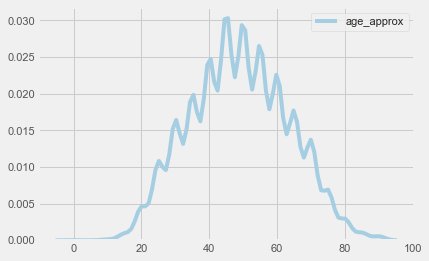

In [16]:
train_data['age'] = train_data['age_approx']

na_age_train = train_data[train_data['age_approx'].isna()==True]
age_train = train_data[train_data['age_approx'].isna()==False]

sns.kdeplot(age_train['age_approx']);

# Impute the missing values with median value of the column
train_data['age'].fillna(age_train['age_approx'].median(), inplace = True) 

Let us also print some numerical statistics of age_approx variable.

In [17]:
train_data['age_approx'].describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

The mean and median of age variable has the same value of 50, while the mode is at 45. The distribution is normal, so we'll use the MEDIAN to impute.

# 3. Analysing Features
## 3.1Analyzing anatom_site_general_challenge feature



No handles with labels found to put in legend.


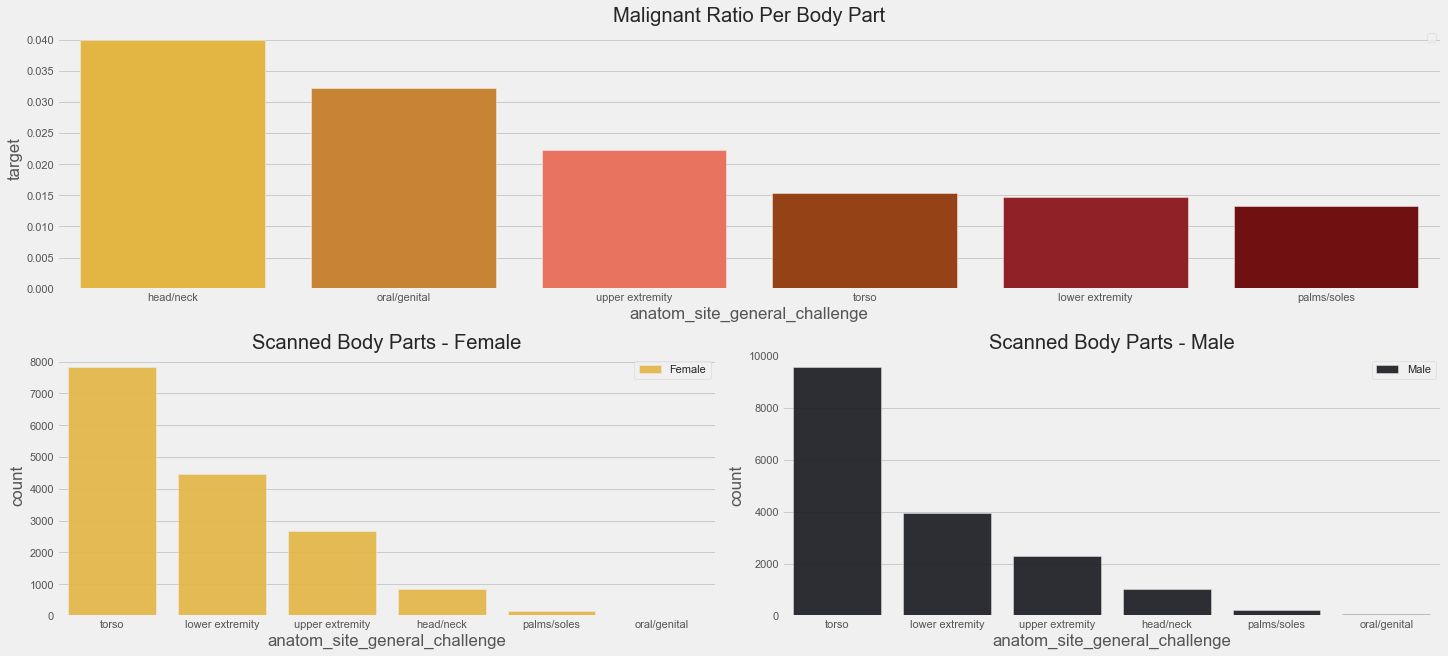

In [18]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[1, :2])
# Set the title.
ax1.set_title('Scanned Body Parts - Female')

# Plot:

sns.countplot(
    train_data[train_data['sex'] == 'female'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#fdc029',
    label='Female',
    order=train_data['anatom_site_general_challenge'].value_counts().index)
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[1, 2:])

# Set the title.

ax2.set_title('Scanned Body Parts - Male')

# Plot.

sns.countplot(
    train_data[train_data['sex'] == 'male'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#171820',
    label='Male',
    order=train_data['anatom_site_general_challenge'].value_counts().index)

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[0, :])

# Set the title.

ax3.set_title('Malignant Ratio Per Body Part')

# Plot.

loc_freq = train_data.groupby('anatom_site_general_challenge')['target'].mean().sort_values(
    ascending=False)
sns.barplot(x=loc_freq.index, y=loc_freq, palette=orange_black, ax=ax3)

ax3.legend()

plt.show()

Looks like some body parts are more likely to be malignant, head/neck comes first with followed by oral/genital and upper extremity. Scanned body part locations are similar in order between males and females with small differences on distribution.

In [19]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train_data,
                  path=['benign_malignant', 'sex', 'anatom_site_general_challenge'],
                  color='sex',
                  color_discrete_sequence=orange_black,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

- Only 2% of our targets are malignant
- On malignant images males are dominant with 62%
- Gender wise benign images are more balance 52-48% male female ratio
- Malignant image scan locations differs based on the patients gender:
- Meanwhile the torso is most common location in males it's almost half of the scans meanwhile in females it's 39%
- Lower extremity is more common with female scans than males 18% males vs 26% females
- Again upper extremity malignant scans is common with females than males (23- 17%)
- Benign image scan locations more similar between male and female patients.

Seeing the output of Test and Train datasets, we will be using 
- "sex", 
- "age_approx", and 
- "anatom_site_general_challenge" as features.

Train features-"benign_malignant", and "diagnosis" are not present in Test. 
Let's do some EDA related to these features


## 3.2 Analysing 'Patient ID' variable 
We are now analyzing the distribution of number of images for each patient.

Number of unique Patient ID's in train set: 2056, Total: 33126
Number of unique Patient ID's in test set: 690, Total: 10982


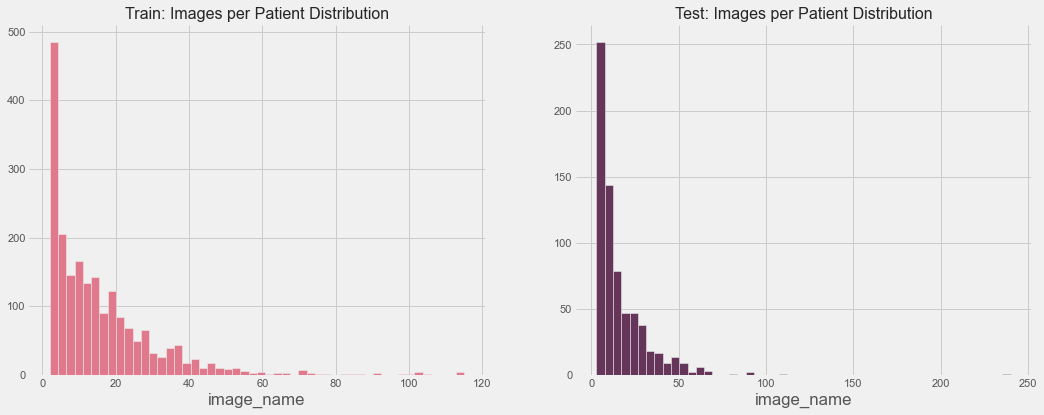

In [20]:
# Count the number of images per ID
print(
    f'Number of unique Patient ID\'s in train set: {train_data.patient_id.nunique()}, Total: {train_data.patient_id.count()}\nNumber of unique Patient ID\'s in test set: {test_data.patient_id.nunique()}, Total: {test_data.patient_id.count()}'
)
patients_count_train = train_data.groupby(by='patient_id')['image_name'].count().reset_index()
patients_count_test = test_data.groupby(by='patient_id')['image_name'].count().reset_index()

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(patients_count_train['image_name'], kde=False, bins=50, 
                 ax=ax1, color=colors_nude[0], hist_kws={'alpha': 1})
b = sns.distplot(patients_count_test['image_name'], kde=False, bins=50, 
                 ax=ax2, color=colors_nude[1], hist_kws={'alpha': 1})
    
ax1.set_title('Train: Images per Patient Distribution', fontsize=16)
ax2.set_title('Test: Images per Patient Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

It looks like we have multiple scan images per patient, actual unique patient counts are much lower than images on both datasets. We can get more information about patients age like when he had his first scan and his last scan. We can get interesting insights like:

- Most of the malignant results are found around first 20 scans. Of course there can be control scans after the diagnosis.
- Scan numbers are similar in first 100 scans but we have 200+ scan images for one particular patient in dataset, it's pretty interesting since we don't have this case in our training data. We should be careful about this and it can effect our model.
- Most of the malignant cases are under 20 images but in general we can say it's more likely to be malignant result if there are more scan images...

No handles with labels found to put in legend.


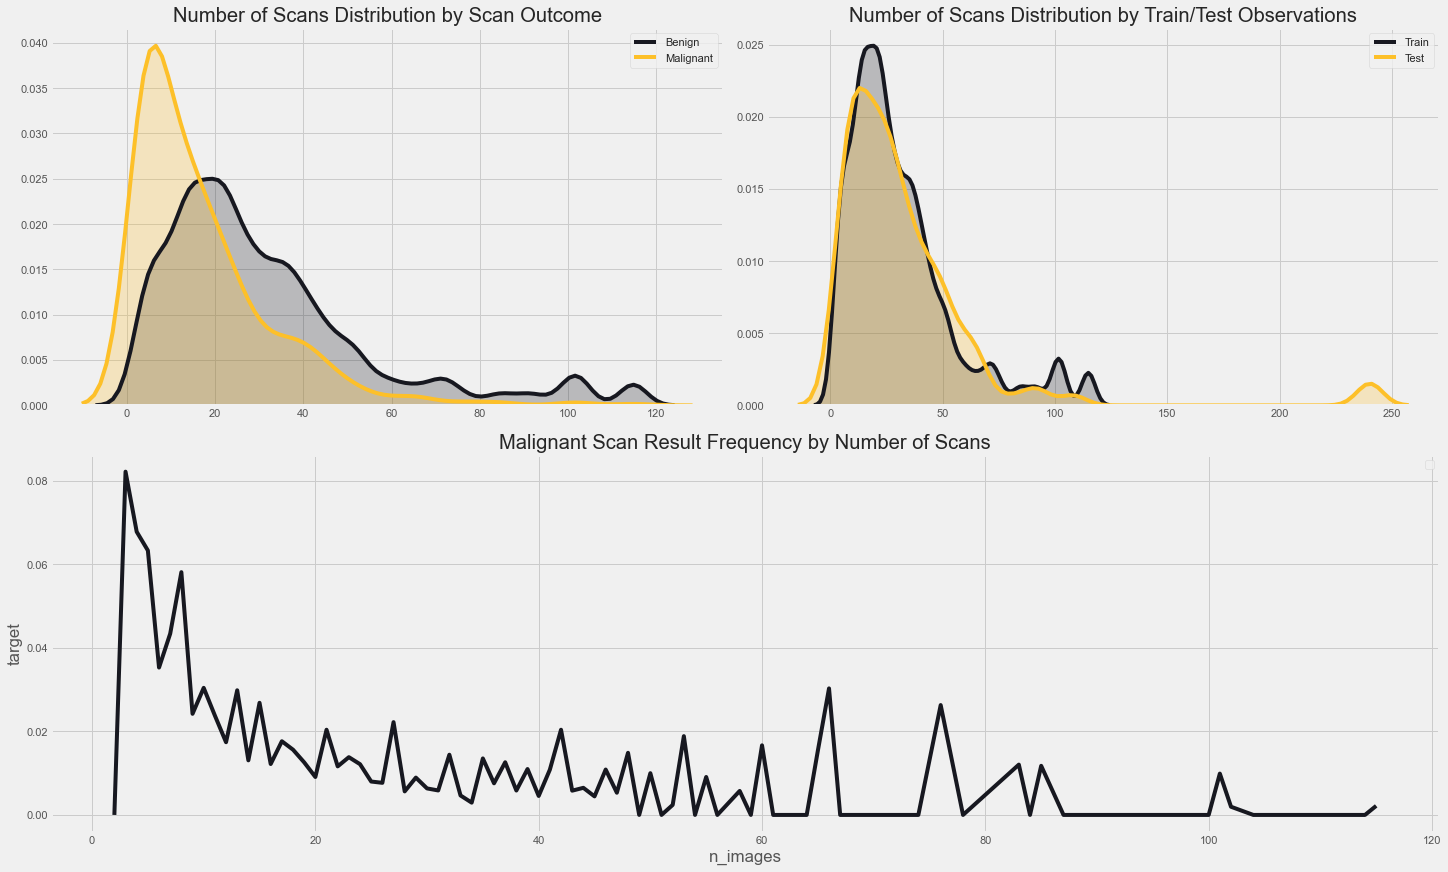

In [21]:
train_data['age_min'] = train_data['patient_id'].map(train_data.groupby(['patient_id']).age_approx.min())
train_data['age_max'] = train_data['patient_id'].map(train_data.groupby(['patient_id']).age_approx.max())

test_data['age_min'] = test_data['patient_id'].map(test_data.groupby(['patient_id']).age_approx.min())
test_data['age_max'] = test_data['patient_id'].map(test_data.groupby(['patient_id']).age_approx.max())
train_data['n_images'] = train_data.patient_id.map(train_data.groupby(['patient_id']).image_name.count())
test_data['n_images'] = test_data.patient_id.map(test_data.groupby(['patient_id']).image_name.count())

# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Number of Scans Distribution by Scan Outcome')

sns.kdeplot(train_data[train_data['target'] == 0]['n_images'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train_data[train_data['target'] == 1]['n_images'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Number of Scans Distribution by Train/Test Observations')

sns.kdeplot(train_data.n_images, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test_data.n_images, label='Test', shade=True, ax=ax2, color='#fdc029')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Malignant Scan Result Frequency by Number of Scans')

z = train_data.groupby('n_images')['target'].mean()
sns.lineplot(x=z.index, y=z, color='#171820', ax=ax3)
ax3.legend()

plt.show()

## 3.3 Analysing Target variable

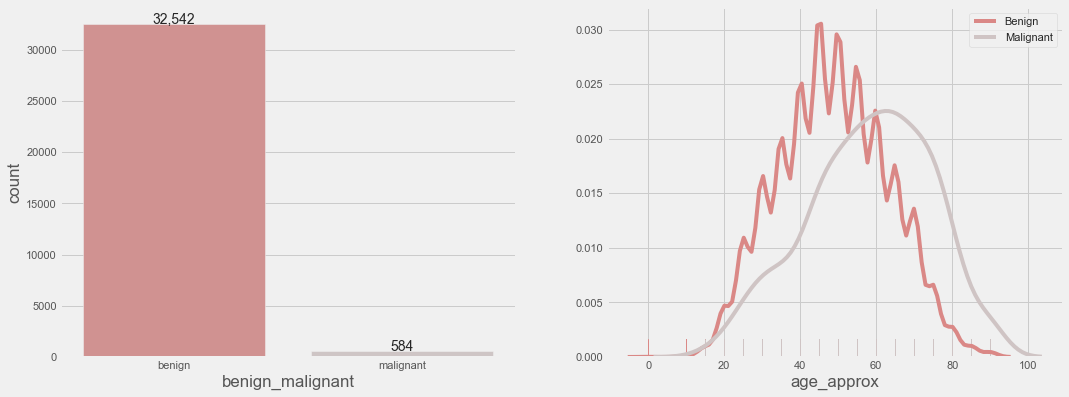

In [22]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(data = train_data, x = 'benign_malignant', palette=colors_nude[2:4],
                 ax=ax1)
b = sns.distplot(a = train_data[train_data['target']==0]['age_approx'], ax=ax2, color=colors_nude[2], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign');
c = sns.distplot(a = train_data[train_data['target']==1]['age_approx'], ax=ax2, color=colors_nude[3], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant');

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points');

total = len(train_data['target'])

plt.show()
    
ax1.set_title('Frequency for Target Variable', fontsize=16);
ax2.set_title('Age Distribution the Target types', fontsize=16);


Very HIGH class imbalance. We need to take this in consideration when Modeling.
- Benign: follows a normal distribution for Age
- Malignant: a little skewed to the left, with the peak oriented towards higher age values.

In [23]:
diag = train_data.diagnosis.value_counts()
fig = px.pie(diag,
             values='diagnosis',
             names=diag.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

## 3.4 Distribution of age of patients for both sex  

firstly, we will group the variable Age into 6 buckets namely,
- between 18-29
- between 30-39
- between 40-49
- between 50-59
- between 60-69
- 70+
- others
 Also, we will analyze if there is any difference in these distributions between Male and Female.

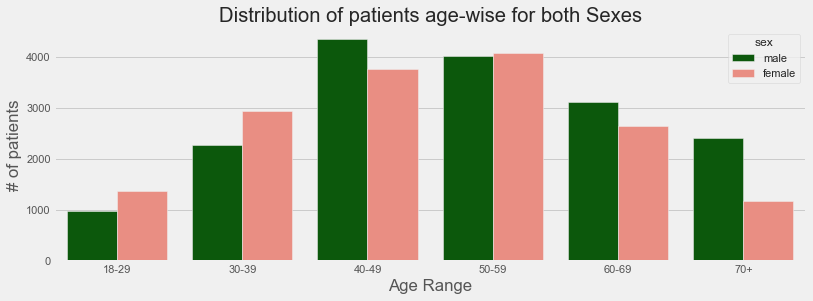

In [24]:
def age_buckets(x): 
    if x < 30: return '18-29' 
    elif x < 40: return '30-39' 
    elif x < 50: return '40-49' 
    elif x < 60: return '50-59' 
    elif x < 70: return '60-69' 
    elif x >=70: return '70+' 
    else: return 'other'

plt.figure(figsize=(12,4))
train_data['age_approx'].fillna((train_data['age_approx'].mean()), inplace=True)
train_data['age_approx'] = train_data['age_approx'].astype(int)
train_data['agerange'] = train_data.age_approx.apply(age_buckets)


sns.countplot(x="agerange", hue='sex', data=train_data, order=['18-29', '30-39', '40-49', '50-59', '60-69', '70+' ], palette=['darkgreen','salmon']);
plt.title('Distribution of patients age-wise for both Sexes');
plt.ylabel('# of patients');
plt.xlabel('Age Range');


From the above graph, we are seeing that Male and Females have similar Age Distributions.

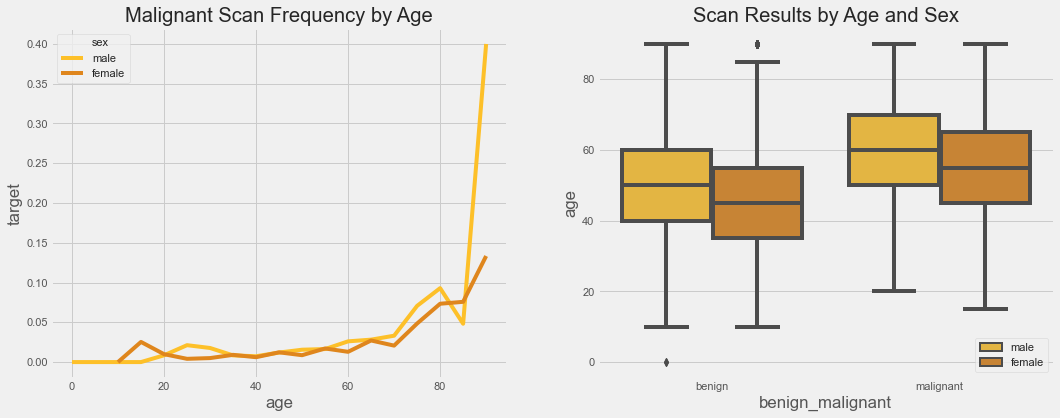

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train_data,
             ax=ax[0],
             hue='sex',
             palette=orange_black[:2],
             ci=None)
sns.boxplot(x='benign_malignant',
            y='age',
            data=train_data,
            ax=ax[1],
            hue='sex',
            palette=orange_black)

plt.legend(loc='lower right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

Age looks pretty decent factor on scan result. 
Getting malignant scan result with elderly age is more possible than young patients. 
There is spike for both genders after age of 85, if we look distribution of ages there isn't much of 80+ patients and it can be the reason of this spike but we can safely say it's more likely to be malignant scan after age of 60. 
We see small bump on age 15-20 for females

No handles with labels found to put in legend.


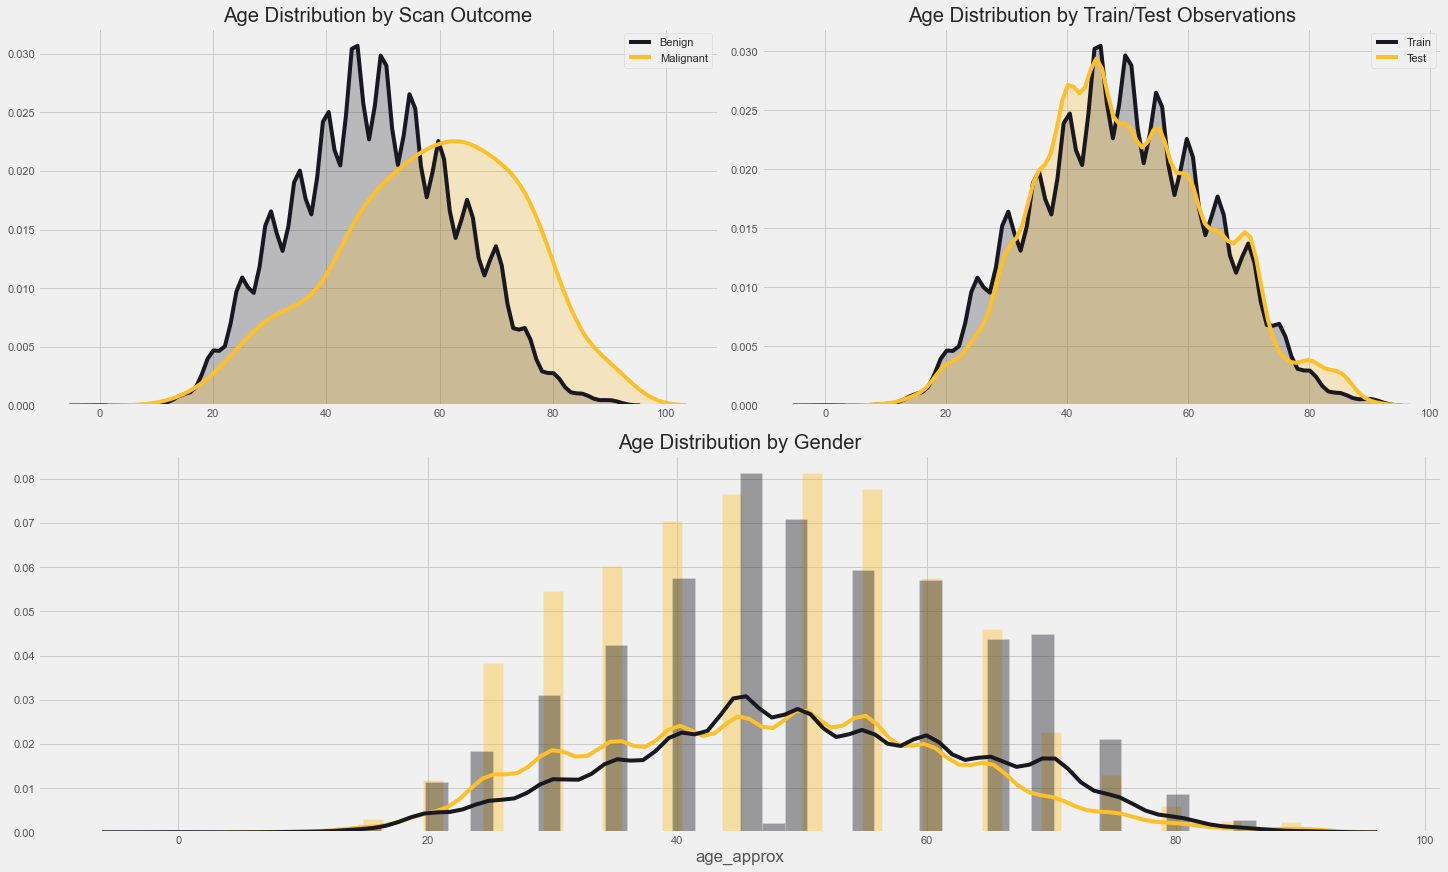

In [26]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Age Distribution by Scan Outcome')
ax1.legend()


sns.kdeplot(train_data[train_data['target'] == 0]['age_approx'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(train_data[train_data['target'] == 1]['age_approx'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Age Distribution by Train/Test Observations')

sns.kdeplot(train_data.age_approx, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(test_data.age_approx, label='Test', shade=True, ax=ax2, color='#fdc029')
ax2.legend()

ax3 = fig.add_subplot(grid[1, :])

ax3.set_title('Age Distribution by Gender')

sns.distplot(train_data[train_data.sex == 'female'].age_approx,
             ax=ax3,
             label='Female',
             color='#fdc029')
sns.distplot(train_data[train_data.sex == 'male'].age_approx,
             ax=ax3,
             label='Male',
             color='#171820')
plt.show()

Age seems evenly distributed on both train and test datasets, we can see small bumps at age 75+ and around 40, these worth investigating.

We can see again older people are more likely to get malignant scan results. One last thing about age distributions, we see more female patients in younger ages this trend changes with the older patients...

Age seems evenly distributed on both train and test datasets, we can see small bumps at age 75+ and around 40, these worth investigating.

We can see again older people are more likely to get malignant scan results. One last thing about age distributions, we see more female patients in younger ages this trend changes with the older patients...

## 3.5 Analysing Colors of Images  

100%|█████████████████████████████████████████████████████████████████████████| 10982/10982 [00:00<00:00, 19284.12it/s]


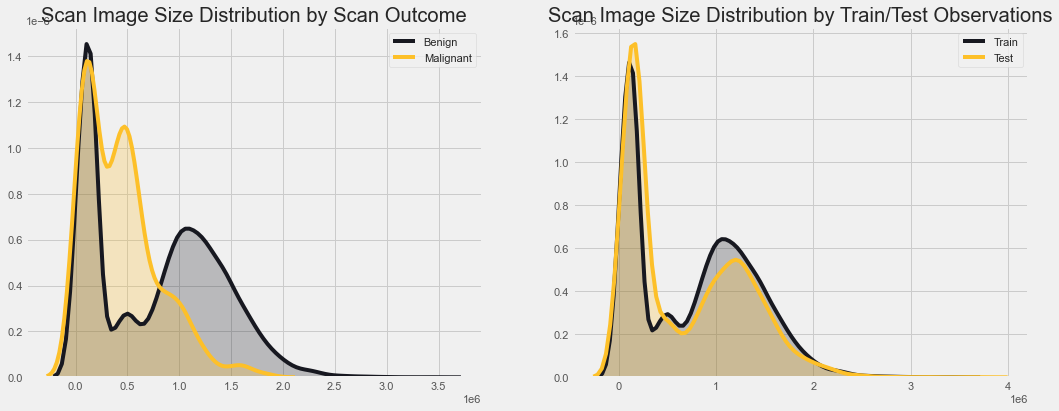

In [30]:
from tqdm import tqdm
import os

# Getting image sizes by using os:
train_img_path = "./data/jpeg/train/"
test_img_path = "./data/jpeg/test/"


for data, location in zip([train_data, test_data], [train_img_path, test_img_path]):
    images = data['image_name'].values
    sizes = np.zeros(images.shape[0])
    for i, path in enumerate(tqdm(images)):
        sizes[i] = os.path.getsize(os.path.join(location, f'{path}.jpg'))

    data['image_size'] = sizes
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(train_data[train_data['target'] == 0]['image_size'],
            shade=True,
            ax=ax[0],
            color='#171820',
            label='Benign')
sns.kdeplot(train_data[train_data['target'] == 1]['image_size'],
            shade=True,
            ax=ax[0],
            color='#fdc029',
            label='Malignant')

sns.kdeplot(train_data.image_size,
            label='Train',
            shade=True,
            ax=ax[1],
            color='#171820')
sns.kdeplot(test_data.image_size,
            label='Test',
            shade=True,
            ax=ax[1],
            color='#fdc029')

ax[0].set_title('Scan Image Size Distribution by Scan Outcome')
ax[1].set_title('Scan Image Size Distribution by Train/Test Observations')

plt.show()

In [37]:
from keras.preprocessing import image
with tf.device('/GPU:0'):
    for data, location in zip([train_data, test_data],[train_img_path, test_img_path]):
       images = data['image_name'].values
       reds = np.zeros(images.shape[0])
       greens = np.zeros(images.shape[0])
       blues = np.zeros(images.shape[0])
       mean = np.zeros(images.shape[0])
       x = np.zeros(images.shape[0], dtype=int)
       y = np.zeros(images.shape[0], dtype=int)
       for i, path in enumerate(tqdm(images)):
           img = np.array(image.load_img(os.path.join(location, f'{path}.jpg')))

           reds[i] = np.mean(img[:,:,0].ravel())
           greens[i] = np.mean(img[:,:,1].ravel())
           blues[i] = np.mean(img[:,:,2].ravel())
           mean[i] = np.mean(img)
           x[i] = img.shape[1]
           y[i] = img.shape[0]

       data['reds'] = reds
       data['greens'] = greens
       data['blues'] = blues
       data['mean_colors'] = mean
       data['width'] = x
       data['height'] = y

   

100%|████████████████████████████████████████████████████████████████████████████| 10982/10982 [32:59<00:00,  5.55it/s]


NameError: name 'train' is not defined

In [43]:
train_data['total_pixels']= train_data['width']*train_data['height']
test_data['total_pixels']= test_data['width']*test_data['height']
train_data['res'] = train_data['width'].astype(str) + 'x' + train_data['height'].astype(str)
test_data['res'] = test_data['width'].astype(str) + 'x' + test_data['height'].astype(str)

train_data['res'] = train_data['width'].astype(str) + 'x' + train_data['height'].astype(str)
test_data['res'] = test_data['width'].astype(str) + 'x' + test_data['height'].astype(str)

train_data.to_pickle("./train_mean_colorres.pkl")
test_data.to_pickle("./test_mean_colorres.pkl")

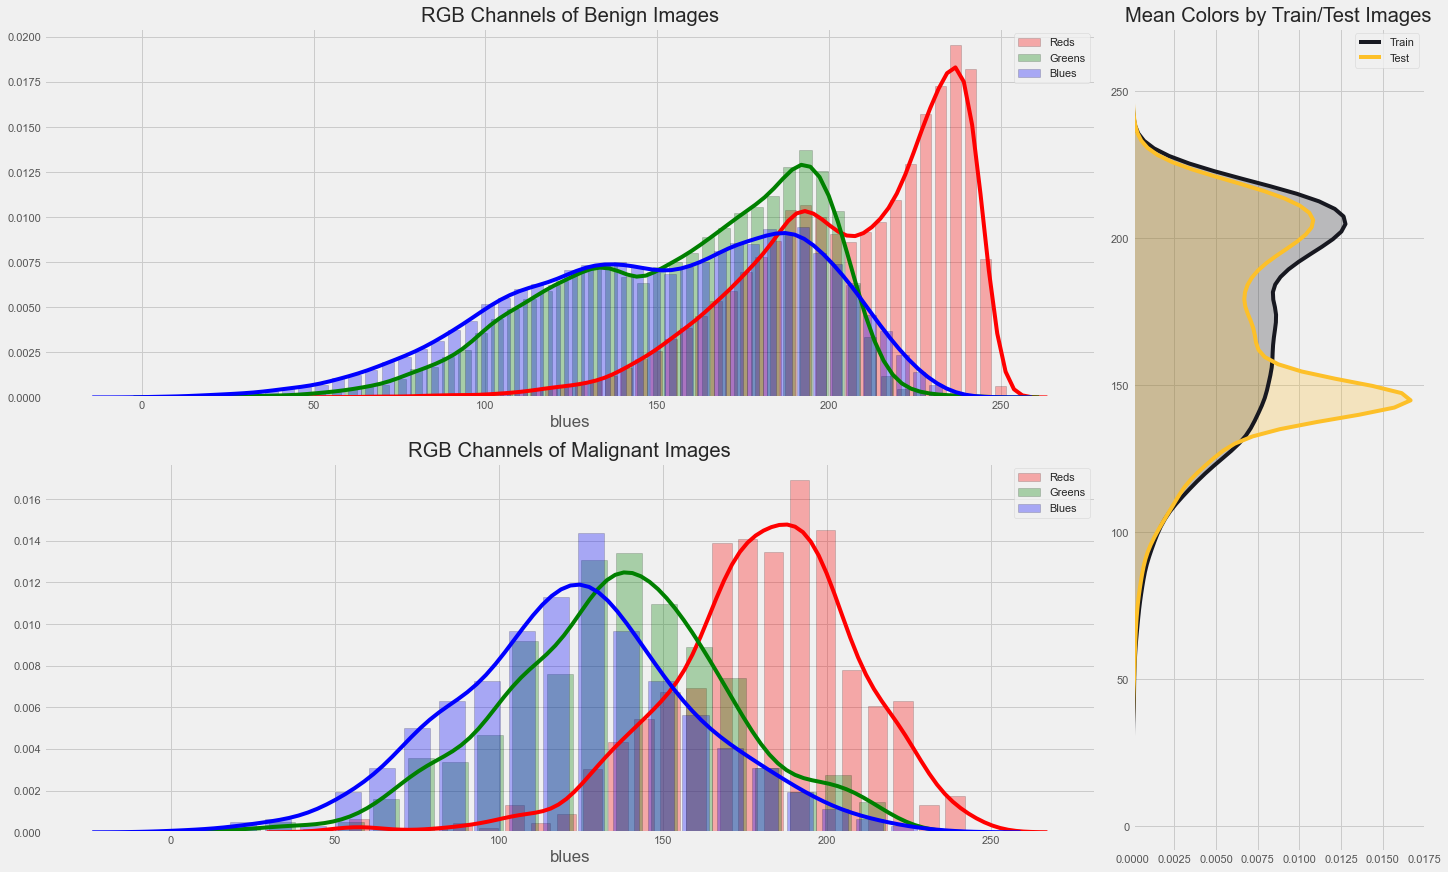

In [44]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('RGB Channels of Benign Images')
sns.distplot(train_data[train_data['target'] == 0].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax1,
             label='Reds')
sns.distplot(train_data[train_data['target'] == 0].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax1,
             label='Greens')
sns.distplot(train_data[train_data['target'] == 0].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax1,
             label='Blues')

ax1.legend()

# Customizing the second grid.
ax2 = fig.add_subplot(grid[1, :2])

# Set the title.

ax2.set_title('RGB Channels of Malignant Images')
sns.distplot(train_data[train_data['target'] == 1].reds,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='red',
             kde=True,
             ax=ax2,
             label='Reds')
sns.distplot(train_data[train_data['target'] == 1].greens,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='green',
             kde=True,
             ax=ax2,
             label='Greens')
sns.distplot(train_data[train_data['target'] == 1].blues,
             hist_kws={
                 'rwidth': 0.75,
                 'edgecolor': 'black',
                 'alpha': 0.3
             },
             color='blue',
             kde=True,
             ax=ax2,
             label='Blues')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Mean Colors by Train/Test Images')
sns.kdeplot(train_data.mean_colors,
            shade=True,
            label='Train',
            ax=ax3,
            color='#171820',
            vertical=True)
sns.kdeplot(test_data.mean_colors,
            shade=True,
            label='Test',
            ax=ax3,
            color='#fdc029',
            vertical=True)
ax3.legend()

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


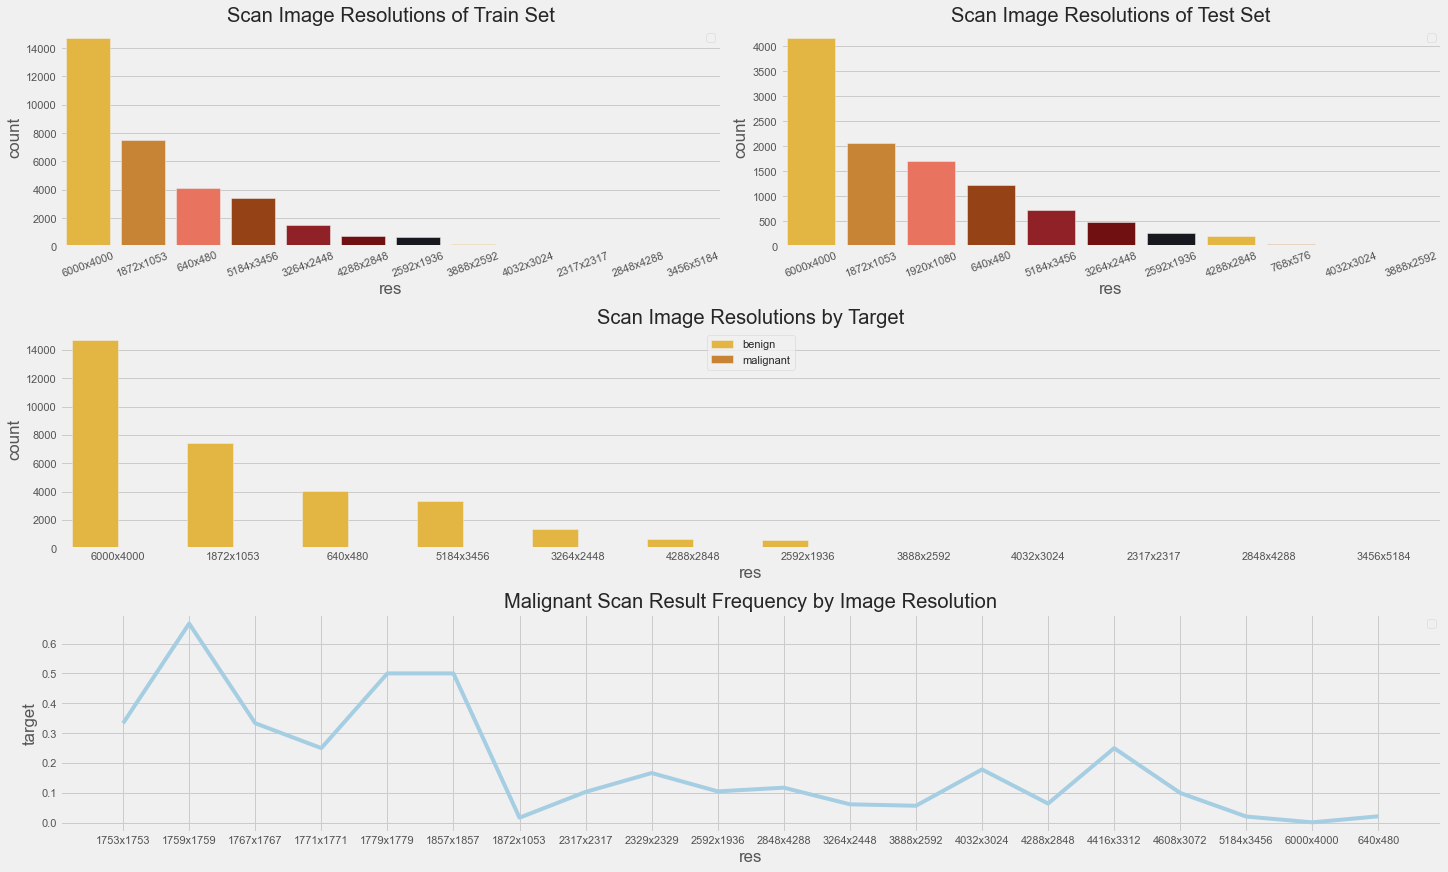

In [45]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid
grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

# Customizing the first grid.
ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Scan Image Resolutions of Train Set')

tres = train_data.res.value_counts().rename_axis('res').reset_index(name='count')
tres = tres[tres['count'] > 10]
sns.barplot(x='res', y='count', data=tres, palette=orange_black, ax=ax1)
plt.xticks(rotation=20)

ax1.legend()

# Customizing the second grid.
ax2 = fig.add_subplot(grid[0, 2:])
ax2.set_title('Scan Image Resolutions of Test Set')
teres = test_data.res.value_counts().rename_axis('res').reset_index(name='count')
teres = teres[teres['count'] > 10]
sns.barplot(x='res', y='count', data=teres, palette=orange_black, ax=ax2)
plt.xticks(rotation=20)
ax2.legend()

# Customizing the third grid.
ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Scan Image Resolutions by Target')
sns.countplot(x='res',
              hue='benign_malignant',
              data=train_data,
              order=train_data.res.value_counts().iloc[:12].index,
              palette=orange_black,
              ax=ax3)
ax3.legend()

# Customizing the last grid.

ax4 = fig.add_subplot(grid[2, :])
ax4.set_title('Malignant Scan Result Frequency by Image Resolution')

# Plot.

res_freq = train_data.groupby('res')['target'].mean()
res_freq = res_freq[(res_freq > 0) & (res_freq < 1)]
sns.lineplot(x=res_freq.index, y=res_freq, palette=orange_black, ax=ax4)
ax4.legend()

plt.show()

From the above 2 sets of plots, We have important observation here, 
- you can see whole 1920x1080 set in test data which is not present in train data. That can have huge impact on final scores, mind that in your models. You might want to leave out image size related info in your models or regularize your models to smooth that effect. It can cause overfitting because of high correlation between image sizes and target, but these correlation might not be the case in test set (most likely) so keep that in mind.

# 4. Evaluation Technique
Submissions are evaluated using "area under the ROC curve" between the predicted probability and the observed target.

# 4. References

1. https://www.kaggle.com/datafan07/analysis-of-melanoma-metadata-and-effnet-ensemble/output?select=blended_effnets.csv